In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm

In [2]:
#Read the input data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Training image shape (55000, 784)
Training labels shape (55000, 10)
Shape of an image (1, 784)


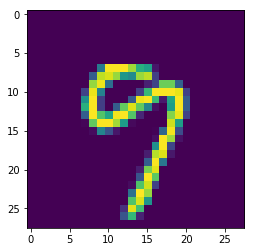

In [3]:
#Explore the data
sample_image = mnist.train.next_batch(1)[0]
print("Training image shape", mnist.train.images.shape)
print("Training labels shape", mnist.train.labels.shape)
print("Shape of an image", sample_image.shape)
sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image)

In [4]:
image_size = 28
labels_size = 10
learning_rate = 0.05
steps_number = 1000
batch_size = 100

In [5]:
# Placeholder is a value that we input when we ask TensorFlow to run a computation.
x = tf.placeholder(tf.float32, shape = [None,784])
y_ = tf.placeholder(tf.float32, shape = [None, 10])

In [6]:
# Functions for weights
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Function for bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution with stride = 1 and padding = 0
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

# Function for max pooling over 2*2 blocks
def max_pooling_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [7]:
# The architecture is similar to https://www.tensorflow.org/get_started/mnist/pros

# Input layer where single input image shape is (1,784)
x_image = tf.reshape(x, [-1,28,28,1])

# Convolution layer 1 - 32 x 5 x 5 
# Conv -> BatchNorm -> Relu -> Max_pool
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = conv2d(x_image, W_conv1) + b_conv1
y1 = tf.nn.relu(tf.layers.batch_normalization(x_conv1))
x_pool1 = max_pooling_2x2(y1)

# Conv layer 2 - 64 x 5 x 5
# Conv -> BatchNorm -> Relu -> Max_pool
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = conv2d(x_pool1, W_conv2) + b_conv2
y2 = tf.nn.relu(tf.layers.batch_normalization(x_conv2))
x_pool2 = max_pooling_2x2(y2)

# Flatten 
x_flat = tf.reshape(x_pool2, [-1, 7 * 7 * 64])

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024]) # max pooling reduced image to 7x7
b_fc1 = bias_variable([1024])
x_fc1 = tf.nn.relu(tf.layers.batch_normalization(tf.matmul(x_flat, W_fc1) + b_fc1))

# Dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

In [8]:
# Probabilities output from model
y = tf.nn.softmax(y_conv)

# Loss and Adam optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [9]:
# Test accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
sess = sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [11]:
# Train model
for i in tqdm(range(1000)):
    batch = mnist.train.next_batch(100)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("Epoch %d, training accuracy %g"%(i, train_accuracy))

    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, training accuracy 0.07


 20%|██        | 200/1000 [02:11<08:47,  1.52it/s]

Epoch 200, training accuracy 0.92


 40%|████      | 400/1000 [04:15<06:23,  1.56it/s]

Epoch 400, training accuracy 0.97


 60%|██████    | 600/1000 [06:12<04:08,  1.61it/s]

Epoch 600, training accuracy 0.96


 80%|████████  | 800/1000 [08:19<02:04,  1.60it/s]

Epoch 800, training accuracy 0.98


100%|██████████| 1000/1000 [10:14<00:00,  1.63it/s]


In [13]:
print(train_accuracy)
print((mnist.test.labels[:,2]))

0.98
[ 0.  1.  0. ...,  0.  0.  0.]


In [14]:
# Fetch 10 2's images
index_mask = np.where(mnist.test.labels[:, 2])[0]
print(index_mask)
subset_mask = np.random.choice(index_mask, 10)
print(subset_mask)

[   1   35   38 ..., 9980 9985 9995]
[7773 3337  256 9700 4905    1 1335 6912 4905 3658]


In [15]:
# Display the labels of the selected images
original_images = mnist.test.images[subset_mask]
original_labels = mnist.test.labels[subset_mask]
original_labels

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [16]:
# Predict the model on the selected 10 2's samples
prediction = tf.argmax(y,1)
prediction_val = prediction.eval(feed_dict={x: original_images, keep_prob: 1.0}, session=sess)
print("predictions", prediction_val)
probabilities = y
probabilities_val = probabilities.eval(feed_dict={x: original_images, keep_prob: 1.0}, session=sess)
print ("probabilities", probabilities_val)

predictions [2 2 2 2 2 2 2 2 2 2]
probabilities [[  1.80184472e-08   2.48554414e-07   9.99968886e-01   2.06626992e-05
    1.39595553e-08   1.19057422e-08   1.17486234e-08   3.67838112e-07
    9.69587927e-06   8.42286525e-08]
 [  5.98078941e-06   1.14633935e-03   9.92992759e-01   3.69481859e-03
    7.15021888e-05   1.79985636e-06   1.22775773e-05   1.94821949e-03
    1.25680323e-04   5.43590659e-07]
 [  3.90892728e-06   1.33079127e-03   9.88985181e-01   9.58858058e-03
    1.82187335e-07   1.36868421e-05   6.68735129e-06   2.74513932e-05
    4.30074506e-05   5.21108291e-07]
 [  8.82295053e-03   1.17119215e-01   4.05954808e-01   1.44047663e-02
    2.78738961e-02   1.40215501e-01   9.19287428e-02   2.29721665e-02
    1.67625353e-01   3.08262371e-03]
 [  5.07109064e-07   3.88321405e-06   9.99620080e-01   3.41601786e-04
    1.86335865e-06   6.99103452e-07   1.98540082e-08   1.09865896e-05
    2.03393283e-05   5.92759477e-08]
 [  1.38996875e-05   3.11168464e-04   9.99208868e-01   2.80713255e-

Correct label 2
Predicted label: 2
Confidence: 0.999969


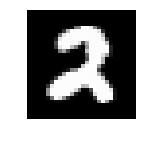

Correct label 2
Predicted label: 2
Confidence: 0.992993


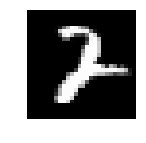

Correct label 2
Predicted label: 2
Confidence: 0.988985


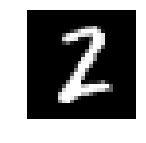

Correct label 2
Predicted label: 2
Confidence: 0.405955


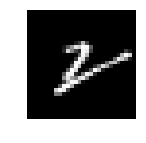

Correct label 2
Predicted label: 2
Confidence: 0.99962


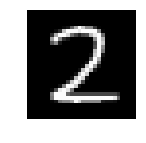

Correct label 2
Predicted label: 2
Confidence: 0.999209


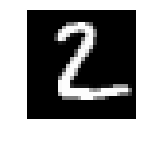

Correct label 2
Predicted label: 2
Confidence: 0.999907


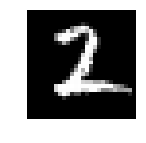

Correct label 2
Predicted label: 2
Confidence: 0.983406


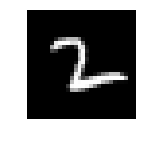

Correct label 2
Predicted label: 2
Confidence: 0.99962


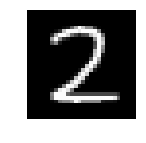

Correct label 2
Predicted label: 2
Confidence: 0.992476


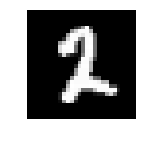

In [17]:
# Show the original images, correct, predicted label and confidence
for i in range(0, 10):
    print('Correct label', np.argmax(original_labels[i]))
    print('Predicted label:', prediction_val[i])
    print('Confidence:', np.max(probabilities_val[i]))
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(original_images[i].reshape([28, 28]),cmap = "gray")
    plt.show()

In [18]:
# Set the target label as 6
target_number = 6
target_labels = np.zeros(original_labels.shape)
target_labels[:, target_number] = 1

In [19]:
target_labels

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])

In [20]:
img_gradient = tf.gradients(cross_entropy, x)[0]

In [21]:
step_size = 0.5 #The amount to wiggle towards the gradient of target class.
steps = 10

In [22]:
#Targeted attack using Fast gradient sign method inspired from http://blog.ycombinator.com/how-adversarial-attacks-work/
# and http://karpathy.github.io/2015/03/30/breaking-convnets/
adversarial_img = original_images.copy()
for i in range(0, steps):
    gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
    #Update using value of gradient
    adversarial_img = adversarial_img - step_size * gradient
    prediction = tf.argmax(y,1)
    prediction_val = prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print("predictions", prediction_val)
    probabilities = y
    probabilities_val = probabilities.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print('Confidence 2:', probabilities_val[:, 2])
    print('Confidence 6:', probabilities_val[:, 6])

predictions [2 2 2 6 2 2 2 2 2 2]
Confidence 2: [ 0.99975914  0.94977903  0.95068485  0.17461015  0.99771428  0.99432278
  0.99942976  0.95363617  0.99771428  0.94765103]
Confidence 6: [  5.68950554e-07   3.90985631e-04   1.14369752e-04   3.76498550e-01
   8.74334432e-07   1.56716432e-03   1.55653051e-05   5.27816918e-03
   8.74333637e-07   4.15910006e-04]
predictions [2 2 2 6 2 2 2 2 2 2]
Confidence 2: [ 0.99806958  0.74058509  0.78998768  0.07288979  0.98630446  0.91312748
  0.99631929  0.80182409  0.98630446  0.806925  ]
Confidence 6: [  2.36430315e-05   7.48124858e-03   2.31651380e-03   6.96408629e-01
   3.79456505e-05   6.12999760e-02   4.41616285e-04   7.58640245e-02
   3.79455741e-05   8.90214089e-03]
predictions [2 2 2 6 2 6 2 2 2 2]
Confidence 2: [ 0.98661405  0.46559685  0.57674742  0.04258141  0.94365585  0.37554571
  0.97691572  0.4142516   0.94365597  0.5709092 ]
Confidence 6: [  6.61006896e-04   4.61501069e-02   2.41652876e-02   8.16159904e-01
   7.17321585e-04   5.745536

In [23]:
step_size = 0.02
steps = 10

In [24]:
adversarial_img = original_images.copy()
adv_img_hist = list()
prob2_hist = list()
prob6_hist = list()
for i in range(0, steps):
    gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
    # Update using sign of gradient and decreasing the step size
    adversarial_img = adversarial_img - step_size * np.sign(gradient)
    adv_img_hist.append(adversarial_img)
    prediction = tf.argmax(y,1)
    prediction_val = prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print("predictions", prediction_val)
    probabilities = y
    probabilities_val = probabilities.eval(feed_dict = {x: adversarial_img, keep_prob: 1.0}, session=sess)
    print('Confidence 2:', probabilities_val[:, 2])
    print('Confidence 6:', probabilities_val[:, 6])
prob2_hist.append(probabilities_val[:,2])
prob6_hist.append(probabilities_val[:,6])

predictions [2 2 2 6 2 2 2 2 2 2]
Confidence 2: [ 0.99983907  0.96345907  0.95229656  0.14154619  0.99819499  0.99511492
  0.99955064  0.95911592  0.99819499  0.96458191]
Confidence 6: [  3.17459921e-07   1.88384234e-04   9.14600460e-05   3.65022719e-01
   4.87396562e-07   1.03932037e-03   8.48577292e-06   3.26479785e-03
   4.87396562e-07   2.24646385e-04]
predictions [2 2 2 6 2 2 2 2 2 2]
Confidence 2: [ 0.99904102  0.83246309  0.84029239  0.03506834  0.99134594  0.95698881
  0.99779058  0.84337634  0.99134594  0.87553167]
Confidence 6: [  8.24675772e-06   3.35220341e-03   1.77920761e-03   8.26140523e-01
   1.38223959e-05   2.32670009e-02   1.69493709e-04   4.99701090e-02
   1.38223959e-05   4.03320882e-03]
predictions [2 2 2 6 2 2 2 2 2 2]
Confidence 2: [ 0.99448591  0.53140134  0.57395995  0.00561629  0.97493309  0.64969152
  0.98813677  0.50775552  0.97493309  0.67416036]
Confidence 6: [  2.02186129e-04   2.87170447e-02   2.05911398e-02   9.74984407e-01
   2.13847306e-04   2.967281

In [25]:
print("Probability of 2 in selected samples ",prob2_hist)
print("Probability of 6 in selected samples ",prob6_hist)

Probability of 2 in selected samples  [array([  5.19961584e-03,   1.57214366e-04,   2.55639345e-04,
         2.19594938e-07,   8.27891286e-03,   1.06333835e-06,
         1.36780291e-04,   7.09484357e-06,   8.27891286e-03,
         2.66365369e-05], dtype=float32)]
Probability of 6 in selected samples  [array([ 0.98842037,  0.99902582,  0.9990114 ,  0.99999881,  0.97181183,
        0.99999595,  0.9995988 ,  0.99997497,  0.97181183,  0.99990582], dtype=float32)]


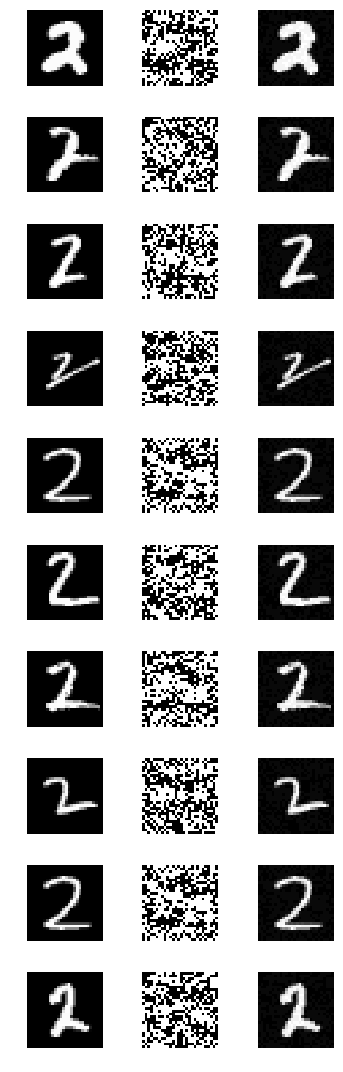

In [26]:
# Generate the image of 10 samples with original_image, delta and adversarial image
f, axarr = plt.subplots(10, 3, figsize=(5,15))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250
for i in range(10):
    axarr[i,0].set_axis_off()
    axarr[i,1].set_axis_off()
    axarr[i,2].set_axis_off()
    axarr[i,0].imshow(original_images[i].reshape([28, 28]), cmap = "gray")
    axarr[i,1].imshow((adv_img_hist[0][i] - original_images[i]).reshape([28, 28]), cmap = "gray")
    axarr[i,2].imshow((adv_img_hist[0][i]).reshape([28, 28]), cmap="gray")
    
plt.tight_layout()
plt.show()
f.savefig("test.png")